## Permutation Test

There are several cases where we would like to perform a permuation test in order to test a hypothesis and learn more about the world. A permutation test is a very useful type of non-parametric test that allows us to make inferences without making statistical assumptions that underly traditional parametric tests.

One insightful example of permutation inference is the reexamination of Student Evaluation of Teaching (SET) data by Boring, Ottoboni, and Stark (2016). In this experiment, 47 students were randomly assigned to one of four sections. There are two TAs that teach two sections each; one TA is male and other is female. In two of the sections, the teaching assistants were introduced using their actual names. In the other two sections, the assistants
switched names.



In [1]:
#HIDDEN 
from IPython.display import Image
display(Image('student_setup2.png'))

 Students never met the teaching assistants face-to-face. Instead, they interacted with the students via an online forum. Homework returns were coordinated so that all students received scores/feedback all at the same time. The 2 TAs also had comparable levels of experience. At the end of the course, students evaluate the TA on promptness in returning assignment.
The authors wanted to investigate if
gender perception has any effect on SETs evaluations/ratings. 


### Experiment Setup



In our **model**, each TA has two possible ratings from each student—one for each perceived gender. Furthermore, each student had an equal chance of being assigned to any one of the (gender, perceived gender) pairs. The students evaluate their TAs independently of
one another.

The **null hypothesis** of this experiment is that perceived gender has no effect on SETs and any observed difference in ratings is due to chance. In other words, the evaluation of each TA should remain unchanged whether they are percieved as a male or a female.
This means that each TA really only has one possible rating from each student.

The **test statistic** that we use the the difference in means of perceived male and perceived female ratings for each TA. Intuitively, we expect this to be close to 0 if gender has no effect on ratings. We can write this formally:

$\\$
$$\mu_{perceived female} - \mu_{percieved male}$$
$\\$
where,

$\\$
$$\mu_{perceived female} = \frac {\sum_{i=1}^{n_1} x_{1i} + \sum_{i=1}^{n_3} x_{3i}}{{n_1} + {n_3}} $$
$\\$
$$\mu_{perceived male} = \frac {\sum_{i=1}^{n_2} x_{2i} + \sum_{i=1}^{n_4} x_{4i}}{{n_2} + {n_4}}$$
$\\$

where $n_i$ is the number of students in the ith group and $x_{ij}$ is the rating of the jth student in the ith group. 

In order to determine whether gender has an effect on SET ratings, we will perform a permutation test in order to get the distribution of the test statistic under the null hypothesis. We will follow the following steps:

* Permute the perceived gender labels for students under the same TA. Note that we are shuffling within the left and right halves in the picture above.
* Compute the difference in average scores for identified-female and identified-male groups. 
* Repeat many times to create an approximate sampling distribution for the difference in average scores for the 2 groups. 
* Use the approximate distribution to estimate the chance of seeing a test statistic more extreme than the one observed.


It is important to understand why the permutation test is justified in this scenario. Under the null model, each student would have given their TA the same rating regardless of perceived gender. Simple random assignment then implies that for a given TA, all of their ratings had an equal chance of showing up under perceived male or perceived female. Therefore, permuting the gender labels should have no effect on the ratings if the null hypothesis were true. 

### The Data

We begin with the student and gender data below. These data are a census of 47 students enrolled in an online course at a U.S. university.



In [3]:
#HIDDEN 
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import pylab
%matplotlib inline

import io

from google.colab import files
uploaded = files.upload()

student_eval = pd.read_csv(io.StringIO(uploaded['StudentRatingsData.csv'].decode('utf-8')))
student_eval = student_eval.loc[:, ["group", "tagender", "taidgender", "prompt"]]
student_eval = student_eval.dropna()
student_eval.head()

Saving StudentRatingsData.csv to StudentRatingsData.csv


,group,tagender,taidgender,prompt
0,3,0,1,4.0
1,3,0,1,5.0
2,3,0,1,5.0
3,3,0,1,5.0
4,3,0,1,3.0


The columns have the following meanings:

**tagender** – the true gender of the TA

**taidgender** – the gender presented to the students

**prompt** – rating on promptness of HW on a scale from 1 to 5



After analyzing and plotting the ratings data from the experiment below,  there appears to be a difference between the groups of students, with perceived female ratings lower than male ratings; however, we need a more formal hypothesis test to see if this difference could simply be due to the random assignment of students.



In [4]:
average_gender_eval = student_eval.loc[:, ["tagender", "taidgender", "prompt"]].groupby(["tagender", "taidgender"]).mean()
average_gender_eval

prompt
tagender taidgender          
0        0           3.750000
         1           4.333333
1        0           3.416667
         1           4.363636

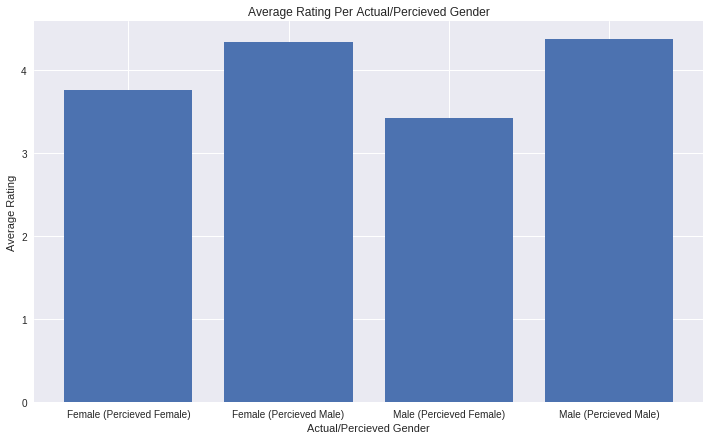

In [20]:
fig, ax = plt.subplots(figsize=(12, 7))
ind = np.arange(4)
plt.bar(ind, average_gender_eval["prompt"])
ax.set_xticks(ind)
ax.set_xticklabels(['Female (Percieved Female)', 'Female (Percieved Male)', 'Male (Percieved Female)', "Male (Percieved Male)"])
ax.set_ylabel('Average Rating')
ax.set_xlabel('Actual/Percieved Gender')
ax.set_title('Average Rating Per Actual/Percieved Gender')
plt.show()

### Performing the Experiment

We will compute the observed difference between the average ratings of the identified male and identified female groups:

In [21]:
percieved_male = student_eval[student_eval["taidgender"] == 1]
percieved_female = student_eval[student_eval["taidgender"] == 0]
observed_difference = np.mean(percieved_female["prompt"]) - np.mean(percieved_male["prompt"])
observed_difference

-0.7978260869565217

We see that the difference is -0.8. In other words, the average for those identified as female is nearly 1 point lower on a scale from 1 to 5.  Given the scale of the ratings, this difference appears to be quite large. By performing a permutation test, we will be able to find the chance of observing a difference this large.

Now, we can permute the perceived gender labels for each TA and calculate the test statistic 1,000 times:

In [22]:
gender_differences = np.array([])
repetitions = 1000

for i in np.arange(repetitions):
  
  true_male = student_eval[student_eval["tagender"] == 1]
  true_female = student_eval[student_eval["tagender"] == 0]
  
  shuffled_male = np.random.permutation(true_male["taidgender"])
  shuffled_female = np.random.permutation(true_female["taidgender"])

  true_male["shuffled gender"] = shuffled_male
  true_female["shuffled gender"] = shuffled_female
  
  percieved_male1 = true_male[true_male["shuffled gender"] == 0]
  percieved_male2 = true_female[true_female["shuffled gender"] == 0]
  percieved_male_rating = np.append(percieved_male1["prompt"], percieved_male2["prompt"])
  percieved_female1 = true_male[true_male["shuffled gender"] == 1]
  percieved_female2 = true_female[true_female["shuffled gender"] == 1]
  percieved_female_rating = np.append(percieved_female1["prompt"], percieved_female2["prompt"])
  
  # Calculate differences
  gender_difference = np.mean(percieved_female_rating) - np.mean(percieved_male_rating)
  gender_differences = np.append(gender_differences, gender_difference)

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


We can now view the approximate sampling distribution of the difference in scores from our permutations.

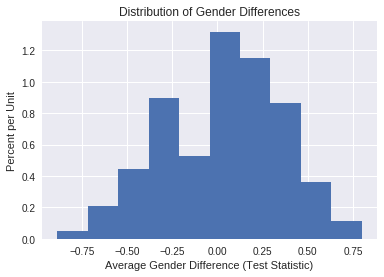

In [29]:
differences_df = pd.DataFrame()
differences_df["gender_differences"] = gender_differences
gender_hist = differences_df.loc[:, "gender_differences"].hist(normed=True)
gender_hist.set_xlabel("Average Gender Difference (Test Statistic)")
gender_hist.set_ylabel("Percent per Unit")
gender_hist.set_title("Distribution of Gender Differences")
plt.show()

From our calculation below, 0 of the 1000 simulations had a difference as large as the one observed. Therefore, our p -value is less than the 0.005 threshold.

In [24]:
num_extreme = np.count_nonzero(gender_differences <= observed_difference)
empirical_P = num_extreme / repetitions
empirical_P

0

### Conclusion

Through this permuatation test, we have shown that SET are biased against female instructors by an amount that is large and statistically significant.

There are other studies that have also tested bias within teaching evaluations. According to Boring, Ottoboni & Stark 2016, there were several other parametric tests conducted that assumed ratings of male and female instructors are independent random samples from normally distributed populations with equal variances; this type of experimental design does not align with the proposed null hypothesis, causing the p-values to be potentially misleading.

In contrast, Boring, Ottoboni & Stark 2016 used permutation tests based on random assignment of students to class sections. Recall that during our permutation test, we did not make any underlying assumptions about the distribution of our data. In this experiment,  we did not assume that students, SET scores, grades, or any other variables comprise random samples from any populations, much less populations with normal distributions.

When testing a hypothesis, it is very important to carefully choose your experiment design and null hypothesis in order to obtain reliable results.